<a href="https://colab.research.google.com/github/NitinShindeJ/TensorFlow2.0/blob/master/My_learn_TF2.0/TF2_0_RNN_LSTM_Nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install Tensor flow
!pip install -q tensorflow==2.0.beta1

     |████████████████████████████████| 87.9MB 63kB/s 
     |████████████████████████████████| 3.1MB 31.5MB/s 
     |████████████████████████████████| 501kB 52.4MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
from tensorflow.keras.layers import SimpleRNN, Input, Dense, LSTM, GRU, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Optimizer, Adam, SGD

In [0]:
# make the original data
series = np.sin((0.1*np.arange(400))**2)

This is a time series of the form:

$$ x(t) = \sin(\omega t^2) $$

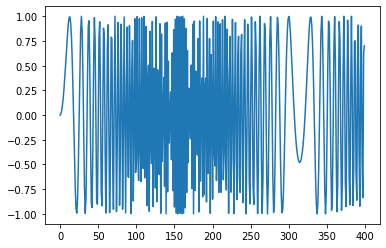

In [5]:
# plot it
plt.plot(series)
plt.show()

In [6]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390,)


In [7]:
### try autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 195 samples, validate on 195 samples
Epoch 1/80
195/195 [==============================] - 0s 661us/sample - loss: 1.4211 - val_loss: 1.3967
Epoch 2/80
195/195 [==============================] - 0s 102us/sample - loss: 1.2187 - val_loss: 1.3061
Epoch 3/80
195/195 [==============================] - 0s 103us/sample - loss: 1.0713 - val_loss: 1.2272
Epoch 4/80
195/195 [==============================] - 0s 95us/sample - loss: 0.9386 - val_loss: 1.1486
Epoch 5/80
195/195 [==============================] - 0s 99us/sample - loss: 0.8370 - val_loss: 1.0720
Epoch 6/80
195/195 [==============================] - 0s 90us/sample - loss: 0.7570 - val_loss: 1.0130
Epoch 7/80
195/195 [==============================] - 0s 140us/sample - loss: 0.6941 - val_loss: 0.9572
Epoch 8/80
195/195 [==============================] - 0s 92us/sample - loss: 0.6476 - val_loss: 0.8997
Epoch 9/80
195/195 [==============================] - 0s 94us/sample - loss: 0.6095 - val_loss: 0.8491
Epoch 10/80
195/195 [==

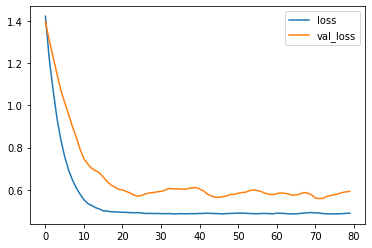

In [8]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(390, 1)


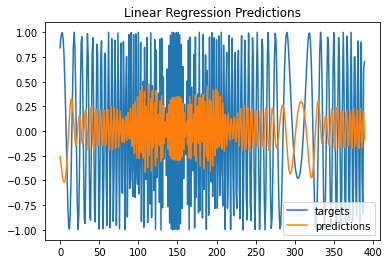

In [9]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()

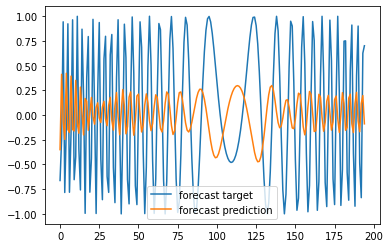

In [10]:
# This is the code we had before - it does the same thing

# One-step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1))[0,0] # 1x1 array -> scalar
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

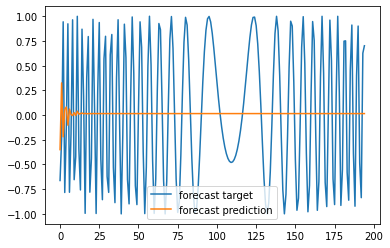

In [11]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [16]:
### Now try RNN model
X = X.reshape(-1, T, 1) # make it N x T x D

# make the RNN
i = Input(shape=(T, D))
x = SimpleRNN(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.05),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  batch_size=32,
  epochs=200,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 195 samples, validate on 195 samples
Epoch 1/200
195/195 [==============================] - 1s 3ms/sample - loss: 0.6735 - val_loss: 0.6308
Epoch 2/200
195/195 [==============================] - 0s 199us/sample - loss: 0.5573 - val_loss: 0.6003
Epoch 3/200
195/195 [==============================] - 0s 180us/sample - loss: 0.5001 - val_loss: 0.6512
Epoch 4/200
195/195 [==============================] - 0s 188us/sample - loss: 0.4981 - val_loss: 0.6099
Epoch 5/200
195/195 [==============================] - 0s 216us/sample - loss: 0.4516 - val_loss: 0.5993
Epoch 6/200
195/195 [==============================] - 0s 190us/sample - loss: 0.4313 - val_loss: 0.5120
Epoch 7/200
195/195 [==============================] - 0s 197us/sample - loss: 0.4097 - val_loss: 0.5480
Epoch 8/200
195/195 [==============================] - 0s 184us/sample - loss: 0.3615 - val_loss: 0.5235
Epoch 9/200
195/195 [==============================] - 0s 192us/sample - loss: 0.2774 - val_loss: 0.3675
Epoch 10/20

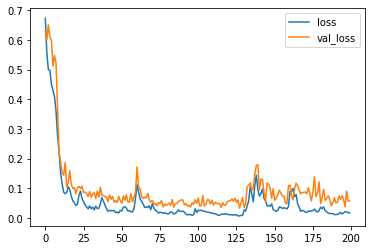

In [17]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(390, 1)


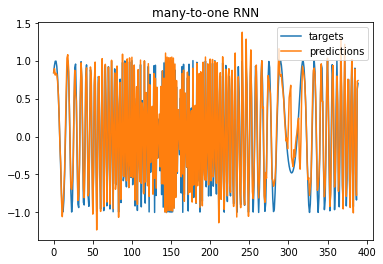

In [18]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("many-to-one RNN")
plt.legend()
plt.show()

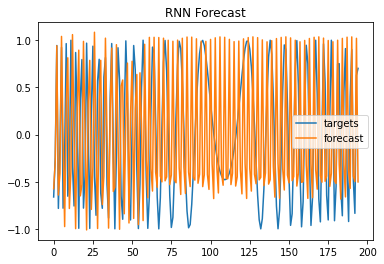

In [19]:
# Multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
  # Reshape the input_ to N x T x D
  f = model.predict(input_.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f

plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("RNN Forecast")
plt.legend()
plt.show()

In [0]:
### Now try RNN/LSTM model
X = X.reshape(-1, T, 1) # make it N x T x D

# make the RNN
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.05),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  batch_size=32,
  epochs=200,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

In [0]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [0]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("many-to-one RNN")
plt.legend()
plt.show()

In [0]:
# Multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
  # Reshape the input_ to N x T x D
  f = model.predict(input_.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f

plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("RNN Forecast")
plt.legend()
plt.show()